# Facial Expression Recognition and Valence/Arousal Prediction

## Overview
This notebook implements a multi-task deep learning approach for:
1. **Facial Expression Classification**: Classifying emotions (Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt)
2. **Valence Prediction**: Predicting positive/negative emotional state [-1, +1]  
3. **Arousal Prediction**: Predicting excitement/calmness level [-1, +1]

## Dataset Information
- **Images**: 224x224 RGB facial images
- **Annotations**: Stored in .npy files with expression labels, valence/arousal values, and facial landmarks

## Models
This notebook focuses on two high-performance architectures:
- **ResNet50**: Deep residual network with skip connections
- **EfficientNetB1**: Optimized architecture with compound scaling

Each model uses transfer learning with multi-task learning for simultaneous emotion classification and valence/arousal regression.

## 1. Import Required Libraries

In [2]:
# Core libraries for deep learning and data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
import warnings
from pathlib import Path
import random
from tqdm import tqdm

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, ResNet101, 
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4,
    MobileNetV2, DenseNet121, InceptionV3, Xception
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Scikit-learn for metrics and preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, roc_auc_score,
    precision_recall_curve, auc, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Statistical and correlation metrics
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

# Visualization and plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configure warnings and display
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# GPU configuration
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training")
    # Configure GPU memory growth
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Using CPU for training")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU for training
TensorFlow version: 2.18.0
Keras version: 3.8.0
NumPy version: 1.26.4
OpenCV version: 4.11.0


In [3]:
# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPU available: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found")

is_kaggle = os.path.exists('/kaggle/input')

GPU available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Configuration and Constants

In [4]:
# Dataset configuration
DATASET_PATH = "Dataset"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")

# Model configuration
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Class labels for emotions
EMOTION_LABELS = {
    0: 'Neutral',
    1: 'Happy', 
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
    7: 'Contempt'
}

NUM_CLASSES = len(EMOTION_LABELS)

# Training configuration
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EARLY_STOPPING_PATIENCE = 8  # Adjusted for 20 epochs
REDUCE_LR_PATIENCE = 4       # Adjusted for 20 epochs

# Model architectures to compare
MODEL_ARCHITECTURES = [
    'VGG16', 'VGG19', 'ResNet50', 'ResNet101',
    'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2',
    'MobileNetV2', 'DenseNet121'
]

# Loss weights for multi-task learning
EMOTION_LOSS_WEIGHT = 1.0
VALENCE_LOSS_WEIGHT = 1.0
AROUSAL_LOSS_WEIGHT = 1.0

print(f"Dataset path: {DATASET_PATH}")
print(f"Images path: {IMAGES_PATH}")
print(f"Annotations path: {ANNOTATIONS_PATH}")
print(f"Input shape: {INPUT_SHAPE}")
print(f"Number of emotion classes: {NUM_CLASSES}")
print(f"Emotion labels: {EMOTION_LABELS}")

Dataset path: Dataset
Images path: Dataset/images
Annotations path: Dataset/annotations
Input shape: (224, 224, 3)
Number of emotion classes: 8
Emotion labels: {0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}


In [5]:
# Auto-detect environment and set appropriate paths
is_kaggle = os.path.exists('/kaggle/input')

if is_kaggle:
    print("Kaggle environment detected - applying optimizations")
    
    # Kaggle-optimized training settings
    BATCH_SIZE = 16  # Reduced for GPU memory efficiency
    EPOCHS = 50      # Reduced for time limits
    EARLY_STOPPING_PATIENCE = 10
    
    # Results path
    RESULTS_PATH = "/kaggle/working"
    
else:
    print("Running locally")
    # Keep original local paths
    DATASET_PATH = "Dataset"
    IMAGES_PATH = os.path.join(DATASET_PATH, "images")
    ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
    RESULTS_PATH = "results"

# Create results directory
if 'RESULTS_PATH' in locals():
    os.makedirs(RESULTS_PATH, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_PATH}")

# Print final configuration
print(f"\nFinal Configuration:")
print(f"   Dataset path: {DATASET_PATH if 'DATASET_PATH' in locals() else 'Not found'}")
print(f"   Images path: {IMAGES_PATH if IMAGES_PATH else 'Not found'}")
print(f"   Annotations path: {ANNOTATIONS_PATH if ANNOTATIONS_PATH else 'Not found'}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")

print("\nUpdating dataset paths for Kaggle")

# Find the actual dataset structure in Kaggle
dataset_root = "/kaggle/input/affect/Dataset/Dataset"
DATASET_PATH = dataset_root

# Auto-detect image and annotation directories
images_found = False
annotations_found = False

for root, dirs, files in os.walk(dataset_root):
    for dir_name in dirs:
        if "image" in dir_name.lower():
            IMAGES_PATH = os.path.join(root, dir_name)
            print(f"Found images in: {IMAGES_PATH}")
            images_found = True
        elif "annotation" in dir_name.lower():
            ANNOTATIONS_PATH = os.path.join(root, dir_name)
            print(f"Found annotations in: {ANNOTATIONS_PATH}")
            annotations_found = True

# If standard names not found, check the root directory contents
if not images_found or not annotations_found:
    print(f"\nContents of {dataset_root}:")
    contents = os.listdir(dataset_root)
    for item in contents:
        item_path = os.path.join(dataset_root, item)
        if os.path.isdir(item_path):
            item_contents = os.listdir(item_path)[:5]
            print(f"   {item}/ contains: {item_contents}")
            
            # Check if this could be images or annotations
            if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in item_contents):
                IMAGES_PATH = item_path
                print(f"   This appears to be the images directory!")
                images_found = True
            elif any(f.endswith('.npy') for f in item_contents):
                ANNOTATIONS_PATH = item_path
                print(f"   This appears to be the annotations directory!")
                annotations_found = True

print(f"\nFinal paths:")
print(f"   Images: {IMAGES_PATH if images_found else 'Not found'}")
print(f"   Annotations: {ANNOTATIONS_PATH if annotations_found else 'Not found'}")

Kaggle environment detected - applying optimizations
Results will be saved to: /kaggle/working

Final Configuration:
   Dataset path: Dataset
   Images path: Dataset/images
   Annotations path: Dataset/annotations
   Batch size: 16
   Epochs: 50

Updating dataset paths for Kaggle
Found annotations in: /kaggle/input/affect/Dataset/Dataset/annotations
Found images in: /kaggle/input/affect/Dataset/Dataset/images

Final paths:
   Images: /kaggle/input/affect/Dataset/Dataset/images
   Annotations: /kaggle/input/affect/Dataset/Dataset/annotations

Final paths:
   Images: /kaggle/input/affect/Dataset/Dataset/images
   Annotations: /kaggle/input/affect/Dataset/Dataset/annotations


In [6]:
# Update paths based on Kaggle dataset structure
print(" Updating dataset paths for Kaggle")

# Set the correct Kaggle dataset path
DATASET_PATH = "/kaggle/input/affect/Dataset"
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")

print(f" Updated Dataset path: {DATASET_PATH}")
print(f"  Updated Images path: {IMAGES_PATH}")
print(f" Updated Annotations path: {ANNOTATIONS_PATH}")

# Verify paths exist
print(f"\n✓ Checking paths:")
print(f"   Dataset exists: {os.path.exists(DATASET_PATH)}")
print(f"   Images exists: {os.path.exists(IMAGES_PATH)}")
print(f"   Annotations exists: {os.path.exists(ANNOTATIONS_PATH)}")

if os.path.exists(IMAGES_PATH):
    image_count = len([f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"   📸 Image files found: {image_count}")

if os.path.exists(ANNOTATIONS_PATH):
    annotation_count = len([f for f in os.listdir(ANNOTATIONS_PATH) if f.endswith('.npy')])
    print(f"    Annotation files found: {annotation_count}")

 Updating dataset paths for Kaggle
 Updated Dataset path: /kaggle/input/affect/Dataset
  Updated Images path: /kaggle/input/affect/Dataset/images
 Updated Annotations path: /kaggle/input/affect/Dataset/annotations

✓ Checking paths:
   Dataset exists: True
   Images exists: False
   Annotations exists: False


In [7]:
# Set the correct final paths
DATASET_PATH = "/kaggle/input/affect/Dataset/Dataset"
IMAGES_PATH = "/kaggle/input/affect/Dataset/Dataset/images"
ANNOTATIONS_PATH = "/kaggle/input/affect/Dataset/Dataset/annotations"

print("Final dataset configuration:")
print(f"Dataset path: {DATASET_PATH}")
print(f"Images path: {IMAGES_PATH}")
print(f"Annotations path: {ANNOTATIONS_PATH}")

# Verify and count files
image_files = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
annotation_files = [f for f in os.listdir(ANNOTATIONS_PATH) if f.endswith('.npy')]

print(f"\nDataset Statistics:")
print(f"   Total image files: {len(image_files)}")
print(f"   Total annotation files: {len(annotation_files)}")

# Expression files breakdown
exp_files = [f for f in annotation_files if '_exp.npy' in f]
val_files = [f for f in annotation_files if '_val.npy' in f]
aro_files = [f for f in annotation_files if '_aro.npy' in f]
lnd_files = [f for f in annotation_files if '_lnd.npy' in f]

print(f"   Expression files: {len(exp_files)}")
print(f"   Valence files: {len(val_files)}")
print(f"   Arousal files: {len(aro_files)}")
print(f"   Landmark files: {len(lnd_files)}")

# Sample verification
file_ids = [f.split('_')[0] for f in exp_files]
sample_ids = file_ids[:5]

for file_id in sample_ids:
    image_file = f"{file_id}.jpg"
    if os.path.exists(os.path.join(IMAGES_PATH, image_file)):
        # Check annotation files
        exp_file = os.path.join(ANNOTATIONS_PATH, f"{file_id}_exp.npy")
        val_file = os.path.join(ANNOTATIONS_PATH, f"{file_id}_val.npy")
        aro_file = os.path.join(ANNOTATIONS_PATH, f"{file_id}_aro.npy")
        
        if os.path.exists(exp_file) and os.path.exists(val_file) and os.path.exists(aro_file):
            print(f"   {file_id}: Image + Annotations available")

Final dataset configuration:
Dataset path: /kaggle/input/affect/Dataset/Dataset
Images path: /kaggle/input/affect/Dataset/Dataset/images
Annotations path: /kaggle/input/affect/Dataset/Dataset/annotations

Dataset Statistics:
   Total image files: 3999
   Total annotation files: 15996
   Expression files: 3999
   Valence files: 3999
   Arousal files: 3999
   Landmark files: 3999
   2820: Image + Annotations available
   1757: Image + Annotations available
   2691: Image + Annotations available
   406: Image + Annotations available
   2966: Image + Annotations available


## 3. Dataset Loading and Exploration

In [8]:
def explore_dataset():
    """Explore the facial expression dataset structure and contents"""
    print("="*50)
    print("DATASET EXPLORATION")
    print("="*50)
    
    # Check if dataset paths exist
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset path not found: {DATASET_PATH}")
        return
    
    if not os.path.exists(IMAGES_PATH):
        print(f"Images path not found: {IMAGES_PATH}")
        return
        
    if not os.path.exists(ANNOTATIONS_PATH):
        print(f"Annotations path not found: {ANNOTATIONS_PATH}")
        return
    
    # Get list of image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(IMAGES_PATH, ext)))
    
    # Get list of annotation files
    annotation_files = glob.glob(os.path.join(ANNOTATIONS_PATH, "*.npy"))
    
    print(f"Dataset path: {DATASET_PATH}")
    print(f"Total image files: {len(image_files)}")
    print(f"Total annotation files: {len(annotation_files)}")
    
    # Analyze annotation types
    exp_files = [f for f in annotation_files if f.endswith('_exp.npy')]
    val_files = [f for f in annotation_files if f.endswith('_val.npy')]
    aro_files = [f for f in annotation_files if f.endswith('_aro.npy')]
    lnd_files = [f for f in annotation_files if f.endswith('_lnd.npy')]
    
    print(f"Expression files: {len(exp_files)}")
    print(f"Valence files: {len(val_files)}")
    print(f"Arousal files: {len(aro_files)}")
    print(f"Landmark files: {len(lnd_files)}")
    
    # Extract unique file IDs
    file_ids = set()
    for f in annotation_files:
        filename = os.path.basename(f)
        file_id = filename.split('_')[0]
        file_ids.add(file_id)
    
    print(f"Unique file IDs: {len(file_ids)}")
    
    return sorted(list(file_ids))

# Explore the dataset
file_ids = explore_dataset()

DATASET EXPLORATION
Dataset path: /kaggle/input/affect/Dataset/Dataset
Total image files: 3999
Total annotation files: 15996
Expression files: 3999
Valence files: 3999
Arousal files: 3999
Landmark files: 3999
Unique file IDs: 3999


## 4. Custom Evaluation Metrics Implementation

In [9]:
def krippendorff_alpha(data, level_of_measurement='interval'):
    """
    Calculate Krippendorf's Alpha for inter-rater reliability
    
    Args:
        data: Array of shape (n_raters, n_items) or (n_items, n_raters)
        level_of_measurement: 'nominal', 'ordinal', 'interval', or 'ratio'
    
    Returns:
        float: Krippendorf's Alpha value
    """
    # Simplified implementation for interval data
    # For complete implementation, use krippendorff library
    from sklearn.metrics import cohen_kappa_score
    
    if data.shape[0] == 2:  # Two raters
        return cohen_kappa_score(data[0], data[1])
    else:
        # For multiple raters, use average pairwise kappa
        kappas = []
        n_raters = data.shape[0]
        for i in range(n_raters):
            for j in range(i+1, n_raters):
                kappa = cohen_kappa_score(data[i], data[j])
                kappas.append(kappa)
        return np.mean(kappas) if kappas else 0.0

def sign_agreement_metric(y_true, y_pred):
    """
    Calculate Sign Agreement Metric (SAGR)
    Penalizes incorrect sign alongside deviation from value
    
    Args:
        y_true: Ground truth values
        y_pred: Predicted values
    
    Returns:
        float: SAGR score
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate sign agreement
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    sign_agreement = np.mean(sign_true == sign_pred)
    
    # Calculate magnitude correlation
    correlation, _ = pearsonr(np.abs(y_true), np.abs(y_pred))
    
    # Combine sign agreement and correlation
    sagr = sign_agreement * correlation if not np.isnan(correlation) else sign_agreement
    
    return sagr

def concordance_correlation_coefficient(y_true, y_pred):
    """
    Calculate Concordance Correlation Coefficient (CCC)
    Combines Pearson correlation with accuracy
    
    Args:
        y_true: Ground truth values
        y_pred: Predicted values
    
    Returns:
        float: CCC value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Pearson correlation coefficient
    correlation, _ = pearsonr(y_true, y_pred)
    
    # Means and variances
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviations
    sd_true = np.sqrt(var_true)
    sd_pred = np.sqrt(var_pred)
    
    # Concordance correlation coefficient
    numerator = 2 * correlation * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
    
    ccc = numerator / denominator if denominator != 0 else 0
    
    return ccc

def evaluate_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calculate comprehensive classification metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_pred_proba: Predicted probabilities (optional)
    
    Returns:
        dict: Dictionary of metric values
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)
    
    # Krippendorf's Alpha (using Cohen's Kappa as approximation)
    metrics['krippendorff_alpha'] = metrics['cohen_kappa']
    
    # AUC metrics (if probabilities provided)
    if y_pred_proba is not None:
        try:
            metrics['auc_roc'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
        except:
            metrics['auc_roc'] = 0.0
        
        try:
            # Calculate AUC-PR for each class and average
            auc_pr_scores = []
            for i in range(y_pred_proba.shape[1]):
                y_true_binary = (y_true == i).astype(int)
                precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_proba[:, i])
                auc_pr = auc(recall, precision)
                auc_pr_scores.append(auc_pr)
            metrics['auc_pr'] = np.mean(auc_pr_scores)
        except:
            metrics['auc_pr'] = 0.0
    
    return metrics

def evaluate_regression_metrics(y_true, y_pred):
    """
    Calculate comprehensive regression metrics
    
    Args:
        y_true: True values
        y_pred: Predicted values
    
    Returns:
        dict: Dictionary of metric values
    """
    metrics = {}
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Basic metrics
    metrics['rmse'] = np.sqrt(np.mean((y_true - y_pred) ** 2))
    metrics['mae'] = np.mean(np.abs(y_true - y_pred))
    metrics['r2'] = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # Correlation
    correlation, p_value = pearsonr(y_true, y_pred)
    metrics['correlation'] = correlation if not np.isnan(correlation) else 0.0
    metrics['correlation_p_value'] = p_value if not np.isnan(p_value) else 1.0
    
    # Custom metrics
    metrics['sagr'] = sign_agreement_metric(y_true, y_pred)
    metrics['ccc'] = concordance_correlation_coefficient(y_true, y_pred)
    
    return metrics

print("✅ Custom evaluation metrics implemented successfully!")
print(" Available classification metrics: accuracy, f1_score, cohen_kappa, krippendorff_alpha, auc_roc, auc_pr")
print(" Available regression metrics: rmse, mae, r2, correlation, sagr, ccc")

✅ Custom evaluation metrics implemented successfully!
 Available classification metrics: accuracy, f1_score, cohen_kappa, krippendorff_alpha, auc_roc, auc_pr
 Available regression metrics: rmse, mae, r2, correlation, sagr, ccc


## 5. Multi-Task CNN Model Architecture

In [10]:
def create_multitask_model(base_model_name='EfficientNetB0', input_shape=INPUT_SHAPE, 
                          num_classes=NUM_CLASSES, trainable_layers=50):
    """
    Create a multi-task CNN model for emotion classification and valence/arousal regression
    
    Args:
        base_model_name (str): Name of the base CNN architecture
        input_shape (tuple): Input shape for images
        num_classes (int): Number of emotion classes
        trainable_layers (int): Number of top layers to make trainable
    
    Returns:
        tensorflow.keras.Model: Compiled multi-task model
    """
    
    # Input layer
    inputs = layers.Input(shape=input_shape, name='image_input')
    
    # Get base model - only ResNet50 and EfficientNetB1 supported
    base_models = {
        'ResNet50': ResNet50,
        'EfficientNetB1': EfficientNetB1
    }
    
    if base_model_name not in base_models:
        raise ValueError(f"Unsupported base model: {base_model_name}")
    
    # Create base model with ImageNet weights
    base_model = base_models[base_model_name](
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    
    # Add global average pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(base_model.output)
    
    # Shared feature layer
    x = layers.Dense(512, activation='relu', name='shared_features')(x)
    x = layers.Dropout(0.5, name='shared_dropout')(x)
    
    # Emotion classification head
    emotion_features = layers.Dense(256, activation='relu', name='emotion_features')(x)
    emotion_features = layers.Dropout(0.3, name='emotion_dropout')(emotion_features)
    emotion_output = layers.Dense(num_classes, activation='softmax', name='emotion_output')(emotion_features)
    
    # Valence regression head
    valence_features = layers.Dense(128, activation='relu', name='valence_features')(x)
    valence_features = layers.Dropout(0.3, name='valence_dropout')(valence_features)
    valence_output = layers.Dense(1, activation='tanh', name='valence_output')(valence_features)
    
    # Arousal regression head
    arousal_features = layers.Dense(128, activation='relu', name='arousal_features')(x)
    arousal_features = layers.Dropout(0.3, name='arousal_dropout')(arousal_features)
    arousal_output = layers.Dense(1, activation='tanh', name='arousal_output')(arousal_features)
    
    # Create model
    model = models.Model(
        inputs=inputs,
        outputs=[emotion_output, valence_output, arousal_output],
        name=f'MultiTask_{base_model_name}'
    )
    
    return model

def compile_multitask_model(model, learning_rate=LEARNING_RATE):
    """
    Compile multi-task model with appropriate loss functions and metrics
    
    Args:
        model: Keras model to compile
        learning_rate: Learning rate for optimizer
    
    Returns:
        Compiled model
    """
    
    # Define losses
    losses = {
        'emotion_output': 'categorical_crossentropy',
        'valence_output': 'mse',
        'arousal_output': 'mse'
    }
    
    # Define loss weights
    loss_weights = {
        'emotion_output': EMOTION_LOSS_WEIGHT,
        'valence_output': VALENCE_LOSS_WEIGHT,
        'arousal_output': AROUSAL_LOSS_WEIGHT
    }
    
    # Define metrics
    metrics = {
        'emotion_output': ['accuracy'],
        'valence_output': ['mae'],
        'arousal_output': ['mae']
    }
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=losses,
        loss_weights=loss_weights,
        metrics=metrics
    )
    
    return model

def get_model_summary(model):
    """
    Get detailed model summary including parameter count
    
    Args:
        model: Keras model
    
    Returns:
        dict: Model statistics
    """
    
    # Count parameters using model.count_params() method
    try:
        total_params = model.count_params()
        
        # Count trainable parameters manually
        trainable_params = 0
        for layer in model.layers:
            if layer.trainable:
                layer_params = sum([np.prod(w.shape) for w in layer.get_weights()])
                trainable_params += layer_params
        
        non_trainable_params = total_params - trainable_params
        
    except:
        # Fallback method
        trainable_params = sum([np.prod(w.shape) for w in model.trainable_weights])
        non_trainable_params = sum([np.prod(w.shape) for w in model.non_trainable_weights])
        total_params = trainable_params + non_trainable_params
    
    stats = {
        'total_parameters': int(total_params),
        'trainable_parameters': int(trainable_params),
        'non_trainable_parameters': int(non_trainable_params),
        'model_size_mb': total_params * 4 / (1024 * 1024),  # Assuming float32
        'layers': len(model.layers)
    }
    
    return stats

print("✅ Multi-task model architecture functions created successfully!")
print("  Available architectures:", MODEL_ARCHITECTURES)
print(" Model outputs: emotion_classification, valence_regression, arousal_regression")

✅ Multi-task model architecture functions created successfully!
  Available architectures: ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'MobileNetV2', 'DenseNet121']
 Model outputs: emotion_classification, valence_regression, arousal_regression


## 6. Training Pipeline and Model Comparison Framework

This section contains the complete training pipeline and framework for comparing multiple CNN architectures. Run the cells below to:

1. **Load and preprocess the dataset**
2. **Create train/validation splits**
3. **Train multiple CNN models**
4. **Evaluate and compare results**
5. **Generate comprehensive performance reports**

### Next Steps:
1. **Run the data loading cell** to load your dataset
2. **Execute the training loop** to train all models
3. **Analyze results** using the evaluation metrics
4. **Compare architectures** to find the best performing model

### Expected Training Time:
- **CPU**: 8-12 hours per model
- **GPU**: 2-4 hours per model
- **Total**: 16-40 hours for all models (depending on hardware)

### Memory Requirements:
- **Minimum**: 8GB RAM
- **Recommended**: 16GB RAM + 6GB GPU memory
- **Batch size**: Adjust based on available memory

## 7. Data Loading and Preprocessing Pipeline

In [11]:
# ADVANCED DATA AUGMENTATION AND DATASET LOADING
import tensorflow as tf

def create_data_augmentation_layer():
    """
    Create data augmentation layer using tf.keras.Sequential
    """
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15),  # ±15 degrees rotation
        tf.keras.layers.RandomZoom(0.1),       # ±10% zoom
        tf.keras.layers.RandomTranslation(0.1, 0.1),  # ±10% translation
        tf.keras.layers.RandomFlip("horizontal"),      # Horizontal flip
        tf.keras.layers.RandomBrightness(0.1),        # ±10% brightness
        tf.keras.layers.RandomContrast(0.1),          # ±10% contrast
    ])
    return data_augmentation

def load_annotations(annotations_path, file_id):
    """Load annotations for a given file ID"""
    try:
        annotations = {}
        
        # Load expression (emotion class)
        exp_path = os.path.join(annotations_path, f"{file_id}_exp.npy")
        if os.path.exists(exp_path):
            annotations['expression'] = np.load(exp_path).item()
        
        # Load valence
        val_path = os.path.join(annotations_path, f"{file_id}_val.npy") 
        if os.path.exists(val_path):
            annotations['valence'] = np.load(val_path).item()
            
        # Load arousal
        aro_path = os.path.join(annotations_path, f"{file_id}_aro.npy")
        if os.path.exists(aro_path):
            annotations['arousal'] = np.load(aro_path).item()
            
        return annotations
        
    except Exception as e:
        return {}

def create_tensorflow_dataset(images, emotions, valences, arousals, batch_size=16, augment=True, training=True):
    """
    Create TensorFlow dataset with data augmentation
    """
    # Convert to tensors
    images_tensor = tf.constant(images, dtype=tf.float32)
    emotions_tensor = tf.constant(emotions, dtype=tf.int32)
    valences_tensor = tf.constant(valences, dtype=tf.float32)
    arousals_tensor = tf.constant(arousals, dtype=tf.float32)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        images_tensor,
        {
            'emotion_output': tf.keras.utils.to_categorical(emotions_tensor, NUM_CLASSES),
            'valence_output': valences_tensor,
            'arousal_output': arousals_tensor
        }
    ))
    
    if training and augment:
        # Apply data augmentation
        augmentation_layer = create_data_augmentation_layer()
        
        def apply_augmentation(image, labels):
            augmented_image = augmentation_layer(image, training=True)
            return augmented_image, labels
        
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def load_and_preprocess_dataset_enhanced(images_path, annotations_path, file_ids, sample_size=1000):
    """Enhanced dataset loading with comprehensive preprocessing"""
    
    print(f"Loading {sample_size} samples for training...")
    print(f"Images path: {images_path}")
    print(f"Annotations path: {annotations_path}")
    print(f"Available file IDs: {len(file_ids)}")
    
    # Sample file IDs
    sample_file_ids = np.random.choice(file_ids, min(sample_size, len(file_ids)), replace=False)
    print(f"Randomly selected {len(sample_file_ids)} samples to load")
    
    images = []
    emotions = []
    valences = []
    arousals = []
    valid_ids = []
    
    # Counters for status tracking
    successful_loads = 0
    image_errors = 0
    annotation_errors = 0
    missing_files = 0
    
    print(f"\nStarting data loading...")
    
    for i, file_id in enumerate(tqdm(sample_file_ids, desc="Loading data")):
        try:
            # Load image
            image_path = os.path.join(images_path, f"{file_id}.jpg")
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
                    image = image.astype(np.float32) / 255.0
                    
                    # Load annotations
                    annotations = load_annotations(annotations_path, file_id)
                    
                    if 'expression' in annotations and 'valence' in annotations and 'arousal' in annotations:
                        # Validate ranges
                        expression = int(annotations['expression'])
                        valence = float(annotations['valence'])
                        arousal = float(annotations['arousal'])
                        
                        # Check if values are valid (not -2 which indicates missing)
                        if expression >= 0 and expression < NUM_CLASSES and abs(valence) <= 1.0 and abs(arousal) <= 1.0:
                            images.append(image)
                            emotions.append(expression)
                            valences.append(valence)
                            arousals.append(arousal)
                            valid_ids.append(file_id)
                            successful_loads += 1
                            
                            # Show progress every 100 samples
                            if (i + 1) % 100 == 0:
                                print(f"Progress: {successful_loads}/{i+1} samples loaded successfully ({successful_loads/(i+1)*100:.1f}%)")
                        else:
                            annotation_errors += 1
                    else:
                        annotation_errors += 1
                        if annotation_errors <= 5:  # Only show first 5 annotation errors
                            print(f"File {file_id}: Missing annotations (exp: {'expression' in annotations}, val: {'valence' in annotations}, aro: {'arousal' in annotations})")
                else:
                    image_errors += 1
                    if image_errors <= 5:  # Only show first 5 image errors
                        print(f"File {file_id}: Failed to read image")
            else:
                missing_files += 1
                if missing_files <= 5:  # Only show first 5 missing files
                    print(f"File {file_id}: Image file not found")
                        
        except Exception as e:
            if i < 10:  # Only show first 10 general errors
                print(f"Error processing {file_id}: {str(e)}")
            continue
    
    # Convert to numpy arrays
    X = np.array(images)
    y_emotions = np.array(emotions)
    y_valence = np.array(valences)
    y_arousal = np.array(arousals)
    
    # Final status report
    print(f"\nLOADING COMPLETE!")
    print(f"   Successfully loaded: {successful_loads} samples")
    print(f"   Image errors: {image_errors}")
    print(f"   Annotation errors: {annotation_errors}")
    print(f"   Missing files: {missing_files}")
    print(f"   Success rate: {successful_loads/len(sample_file_ids)*100:.1f}%")
    
    if len(X) > 0:
        print(f"\nDATASET STATISTICS:")
        print(f"   Image shape: {X.shape}")
        print(f"   Emotion distribution: {np.bincount(y_emotions)}")
        print(f"   Emotion range: [{y_emotions.min()}, {y_emotions.max()}]")
        print(f"   Valence range: [{y_valence.min():.3f}, {y_valence.max():.3f}]")
        print(f"   Arousal range: [{y_arousal.min():.3f}, {y_arousal.max():.3f}]")
        print(f"   Data augmentation: ENABLED (rotation, zoom, translation, flip, brightness, contrast)")
        print(f"   Ready for training!")
    else:
        print(f"\nLOADING FAILED: No valid samples loaded!")
        print(f"   Check paths and file availability")
    
    return X, y_emotions, y_valence, y_arousal, valid_ids

# Get file IDs from existing exploration
file_ids = sorted([f.split('_')[0] for f in os.listdir(ANNOTATIONS_PATH) if f.endswith('_exp.npy')])

print(f"Available file IDs: {len(file_ids)}")
print(f"Enhanced dataset loading with data augmentation ready!")

# Load dataset with enhanced preprocessing
SAMPLE_SIZE = 1000  # Balanced sample size for training

X, y_emotions, y_valence, y_arousal, valid_ids = load_and_preprocess_dataset_enhanced(
    IMAGES_PATH, ANNOTATIONS_PATH, file_ids, sample_size=SAMPLE_SIZE
)

Available file IDs: 3999
Enhanced dataset loading with data augmentation ready!
Loading 1000 samples for training...
Images path: /kaggle/input/affect/Dataset/Dataset/images
Annotations path: /kaggle/input/affect/Dataset/Dataset/annotations
Available file IDs: 3999
Randomly selected 1000 samples to load

Starting data loading...


Loading data:  10%|█         | 105/1000 [00:02<00:22, 39.90it/s]

Progress: 100/100 samples loaded successfully (100.0%)


Loading data:  21%|██        | 207/1000 [00:05<00:20, 37.85it/s]

Progress: 200/200 samples loaded successfully (100.0%)


Loading data:  30%|███       | 305/1000 [00:08<00:18, 37.06it/s]

Progress: 300/300 samples loaded successfully (100.0%)


Loading data:  41%|████      | 406/1000 [00:10<00:16, 36.98it/s]

Progress: 400/400 samples loaded successfully (100.0%)


Loading data:  51%|█████     | 507/1000 [00:13<00:12, 39.00it/s]

Progress: 500/500 samples loaded successfully (100.0%)


Loading data:  61%|██████    | 607/1000 [00:15<00:10, 38.18it/s]

Progress: 600/600 samples loaded successfully (100.0%)


Loading data:  71%|███████   | 706/1000 [00:18<00:07, 38.15it/s]

Progress: 700/700 samples loaded successfully (100.0%)


Loading data:  80%|████████  | 804/1000 [00:21<00:04, 40.40it/s]

Progress: 800/800 samples loaded successfully (100.0%)


Loading data:  91%|█████████ | 907/1000 [00:23<00:02, 38.21it/s]

Progress: 900/900 samples loaded successfully (100.0%)


Loading data: 100%|██████████| 1000/1000 [00:26<00:00, 38.09it/s]



Progress: 1000/1000 samples loaded successfully (100.0%)

LOADING COMPLETE!
   Successfully loaded: 1000 samples
   Image errors: 0
   Annotation errors: 0
   Missing files: 0
   Success rate: 100.0%

DATASET STATISTICS:
   Image shape: (1000, 224, 224, 3)
   Emotion distribution: [118 126 128 114 124 131 123 136]
   Emotion range: [0, 7]
   Valence range: [-0.962, 0.982]
   Arousal range: [-0.627, 0.968]
   Data augmentation: ENABLED (rotation, zoom, translation, flip, brightness, contrast)
   Ready for training!


## 8. Training Pipeline and Model Comparison

## 9. Model Evaluation and Results Analysis

##  Complete Training Pipeline for All Models

**Ready to train all CNN architectures!** 

The cell below contains the complete training setup for all models. **Uncomment and run it** when you're ready for full training:

- **Dataset**: All 3,999 samples
- **Models**: All 9 CNN architectures  
- **Training**: 50 epochs with early stopping
- **Evaluation**: Complete metrics comparison

**⚠️ Expected Training Time: 15-25 hours on Kaggle GPUs**

## Efficient Model Screening Strategy

To optimize training time and resource usage, we'll implement a two-phase approach:

**Phase 1: Quick Screening (5 epochs each)**
- Test 6 best CNN models for facial expression recognition
- Identify top 3 performers based on validation metrics
- Estimated time: 2-3 hours

**Phase 2: Full Training (25-30 epochs)**
- Train only the top 3 models with full epochs
- Comprehensive evaluation and comparison
- Estimated time: 3-4 hours

**Total estimated time: 5-7 hours (vs 15-25 hours for all models)**

## Phase 2: Full Training of Top Models

Now we'll train the top 3 performing models with full epochs for comprehensive evaluation.

## Final Results Summary and Comparison

Comprehensive comparison of the top performing models with detailed metrics and recommendations.

## Full Training Pipeline - All Models (20 Epochs)

With Tesla P100 confirmed, we'll now train all 9 CNN architectures with optimized settings:
- **20 epochs** with early stopping
- **Fine-tuned hyperparameters** for P100
- **Advanced callbacks** for optimal training
- **Memory optimization** for 16GB GPU
- **Comprehensive evaluation** for each model

In [12]:
# ENHANCED EVALUATION WITH ALL REQUIRED METRICS
MODEL_ARCHITECTURES = ['ResNet50', 'EfficientNetB1']

# COMPREHENSIVE MODEL EVALUATION FUNCTION
def evaluate_model_comprehensive_enhanced(model, X_test, y_test_dict, model_name):
    """
    Enhanced comprehensive evaluation of multi-task model with ALL required metrics
    """
    print(f"Evaluating {model_name} with comprehensive metrics...")
    
    # Make predictions
    predictions = model.predict(X_test, batch_size=32, verbose=0)
    
    # Extract predictions for each task
    y_emotion_pred = predictions[0]  # Emotion classification logits
    y_valence_pred = predictions[1].flatten()  # Valence regression
    y_arousal_pred = predictions[2].flatten()  # Arousal regression
    
    # Ground truth
    y_emotion_true = y_test_dict['emotion_output']
    y_valence_true = y_test_dict['valence_output']
    y_arousal_true = y_test_dict['arousal_output']
    
    # Convert emotion predictions to class predictions
    y_emotion_pred_classes = np.argmax(y_emotion_pred, axis=1)
    y_emotion_true_classes = np.argmax(y_emotion_true, axis=1)
    
    # ===========================================
    # CLASSIFICATION METRICS (All Required)
    # ===========================================
    emotion_metrics = {}
    
    # Basic classification metrics
    emotion_metrics['accuracy'] = accuracy_score(y_emotion_true_classes, y_emotion_pred_classes)
    emotion_metrics['f1_score'] = f1_score(y_emotion_true_classes, y_emotion_pred_classes, average='weighted')
    emotion_metrics['cohen_kappa'] = cohen_kappa_score(y_emotion_true_classes, y_emotion_pred_classes)
    
    # Krippendorff's Alpha (simplified version using Cohen's Kappa)
    emotion_metrics['krippendorff_alpha'] = emotion_metrics['cohen_kappa']
    
    # AUC-ROC (Area Under ROC Curve)
    try:
        emotion_metrics['auc_roc'] = roc_auc_score(y_emotion_true, y_emotion_pred, multi_class='ovr', average='macro')
    except Exception as e:
        print(f"Warning: AUC-ROC calculation failed: {e}")
        emotion_metrics['auc_roc'] = 0.0
    
    # AUC-PR (Area Under Precision-Recall Curve)
    try:
        auc_pr_scores = []
        for i in range(y_emotion_pred.shape[1]):
            y_true_binary = (y_emotion_true_classes == i).astype(int)
            precision, recall, _ = precision_recall_curve(y_true_binary, y_emotion_pred[:, i])
            auc_pr = auc(recall, precision)
            auc_pr_scores.append(auc_pr)
        emotion_metrics['auc_pr'] = np.mean(auc_pr_scores)
    except Exception as e:
        print(f"Warning: AUC-PR calculation failed: {e}")
        emotion_metrics['auc_pr'] = 0.0
    
    # ===========================================
    # REGRESSION METRICS (All Required)
    # ===========================================
    
    # Valence regression metrics
    valence_metrics = {}
    valence_metrics['rmse'] = np.sqrt(np.mean((y_valence_true - y_valence_pred) ** 2))
    valence_metrics['mae'] = np.mean(np.abs(y_valence_true - y_valence_pred))
    valence_metrics['r2'] = 1 - (np.sum((y_valence_true - y_valence_pred) ** 2) / np.sum((y_valence_true - np.mean(y_valence_true)) ** 2))
    
    # Correlation (CORR)
    try:
        correlation, p_value = pearsonr(y_valence_true, y_valence_pred)
        valence_metrics['correlation'] = correlation if not np.isnan(correlation) else 0.0
        valence_metrics['correlation_p_value'] = p_value if not np.isnan(p_value) else 1.0
    except:
        valence_metrics['correlation'] = 0.0
        valence_metrics['correlation_p_value'] = 1.0
    
    # Sign Agreement Metric (SAGR)
    valence_metrics['sagr'] = sign_agreement_metric(y_valence_true, y_valence_pred)
    
    # Concordance Correlation Coefficient (CCC)
    valence_metrics['ccc'] = concordance_correlation_coefficient(y_valence_true, y_valence_pred)
    
    # Arousal regression metrics
    arousal_metrics = {}
    arousal_metrics['rmse'] = np.sqrt(np.mean((y_arousal_true - y_arousal_pred) ** 2))
    arousal_metrics['mae'] = np.mean(np.abs(y_arousal_true - y_arousal_pred))
    arousal_metrics['r2'] = 1 - (np.sum((y_arousal_true - y_arousal_pred) ** 2) / np.sum((y_arousal_true - np.mean(y_arousal_true)) ** 2))
    
    # Correlation (CORR)
    try:
        correlation, p_value = pearsonr(y_arousal_true, y_arousal_pred)
        arousal_metrics['correlation'] = correlation if not np.isnan(correlation) else 0.0
        arousal_metrics['correlation_p_value'] = p_value if not np.isnan(p_value) else 1.0
    except:
        arousal_metrics['correlation'] = 0.0
        arousal_metrics['correlation_p_value'] = 1.0
    
    # Sign Agreement Metric (SAGR)
    arousal_metrics['sagr'] = sign_agreement_metric(y_arousal_true, y_arousal_pred)
    
    # Concordance Correlation Coefficient (CCC)
    arousal_metrics['ccc'] = concordance_correlation_coefficient(y_arousal_true, y_arousal_pred)
    
    # ===========================================
    # DETAILED RESULTS DISPLAY
    # ===========================================
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION RESULTS: {model_name}")
    print(f"{'='*60}")
    
    print(f"\n🎯 EMOTION CLASSIFICATION METRICS:")
    print(f"   Accuracy:              {emotion_metrics['accuracy']:.4f}")
    print(f"   F1-Score:              {emotion_metrics['f1_score']:.4f}")
    print(f"   Cohen's Kappa:         {emotion_metrics['cohen_kappa']:.4f}")
    print(f"   Krippendorff's Alpha:  {emotion_metrics['krippendorff_alpha']:.4f}")
    print(f"   AUC-ROC:               {emotion_metrics['auc_roc']:.4f}")
    print(f"   AUC-PR:                {emotion_metrics['auc_pr']:.4f}")
    
    print(f"\n📊 VALENCE REGRESSION METRICS:")
    print(f"   RMSE:                  {valence_metrics['rmse']:.4f}")
    print(f"   MAE:                   {valence_metrics['mae']:.4f}")
    print(f"   R²:                    {valence_metrics['r2']:.4f}")
    print(f"   Correlation (CORR):    {valence_metrics['correlation']:.4f}")
    print(f"   SAGR:                  {valence_metrics['sagr']:.4f}")
    print(f"   CCC:                   {valence_metrics['ccc']:.4f}")
    
    print(f"\n📈 AROUSAL REGRESSION METRICS:")
    print(f"   RMSE:                  {arousal_metrics['rmse']:.4f}")
    print(f"   MAE:                   {arousal_metrics['mae']:.4f}")
    print(f"   R²:                    {arousal_metrics['r2']:.4f}")
    print(f"   Correlation (CORR):    {arousal_metrics['correlation']:.4f}")
    print(f"   SAGR:                  {arousal_metrics['sagr']:.4f}")
    print(f"   CCC:                   {arousal_metrics['ccc']:.4f}")
    
    # Combined results dictionary
    results = {
        'emotion_metrics': emotion_metrics,
        'valence_metrics': valence_metrics,
        'arousal_metrics': arousal_metrics,
        'predictions': {
            'emotion_pred': y_emotion_pred,
            'emotion_pred_classes': y_emotion_pred_classes,
            'valence_pred': y_valence_pred,
            'arousal_pred': y_arousal_pred
        },
        'ground_truth': {
            'emotion_true': y_emotion_true_classes,
            'valence_true': y_valence_true,
            'arousal_true': y_arousal_true
        }
    }
    
    return results

print("✅ Enhanced evaluation function ready with ALL required metrics!")
print("📋 Classification metrics: Accuracy, F1-Score, Cohen's Kappa, Krippendorff's Alpha, AUC-ROC, AUC-PR")
print("📊 Regression metrics: RMSE, MAE, R², Correlation (CORR), SAGR, CCC")

✅ Enhanced evaluation function ready with ALL required metrics!
📋 Classification metrics: Accuracy, F1-Score, Cohen's Kappa, Krippendorff's Alpha, AUC-ROC, AUC-PR
📊 Regression metrics: RMSE, MAE, R², Correlation (CORR), SAGR, CCC


In [13]:
# ENHANCED TRAINING PIPELINE WITH DATA AUGMENTATION
import time

def train_model_enhanced(model_name):
    """
    Enhanced training function with data augmentation and comprehensive evaluation
    """
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name} WITH DATA AUGMENTATION")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    try:
        # Create model
        print(f"📋 Creating {model_name} architecture...")
        model = create_multitask_model(model_name)
        model = compile_multitask_model(model)
        
        # Print model summary
        print(f"📊 Model Parameters: {model.count_params():,}")
        
        # Create augmented datasets
        print(f"🔄 Setting up data augmentation...")
        train_dataset = create_tensorflow_dataset(
            X_train, y_emotions_train, y_valence_train, y_arousal_train,
            batch_size=BATCH_SIZE, augment=True, training=True
        )
        
        val_dataset = create_tensorflow_dataset(
            X_val, y_emotions_val, y_valence_val, y_arousal_val,
            batch_size=BATCH_SIZE, augment=False, training=False
        )
        
        print(f"✅ Data augmentation enabled: rotation, zoom, translation, flip, brightness, contrast")
        
        # Training callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=REDUCE_LR_PATIENCE,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f"🚀 Starting training for {EPOCHS} epochs...")
        print(f"📊 Training samples: {X_train.shape[0]}")
        print(f"📊 Validation samples: {X_val.shape[0]}")
        
        # Train model with augmented data
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate model with comprehensive metrics
        print(f"🔍 Running comprehensive evaluation...")
        y_val_dict = {
            'emotion_output': tf.keras.utils.to_categorical(y_emotions_val, NUM_CLASSES),
            'valence_output': y_valence_val,
            'arousal_output': y_arousal_val
        }
        
        results = evaluate_model_comprehensive_enhanced(model, X_val, y_val_dict, model_name)
        
        training_time = time.time() - start_time
        results['training_time'] = training_time
        results['epochs_completed'] = len(history.history['loss'])
        results['total_parameters'] = model.count_params()
        
        print(f"\n⏱️  Training completed in {training_time/60:.1f} minutes")
        print(f"📈 Epochs completed: {results['epochs_completed']}")
        print(f"🔧 Total parameters: {results['total_parameters']:,}")
        
        return model, results, history
        
    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)}")
        training_time = time.time() - start_time
        error_result = {
            'error': str(e), 
            'training_time': training_time,
            'epochs_completed': 0,
            'total_parameters': 0
        }
        return None, error_result, None

def train_both_models_enhanced():
    """
    Train both ResNet50 and EfficientNetB1 models with data augmentation
    """
    print("="*80)
    print("ENHANCED TRAINING: RESNET50 AND EFFICIENTNETB1 WITH DATA AUGMENTATION")
    print("="*80)
    
    # Check data availability
    if not all(var in globals() for var in ['X_train', 'X_val', 'y_emotions_train', 'y_emotions_val']):
        print("❌ Error: Training data not available. Please run data loading first.")
        return None, None, None
    
    print(f"📊 Dataset Information:")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Validation samples: {X_val.shape[0]}")
    print(f"   Image shape: {X_train.shape[1:]}")
    print(f"   Emotion classes: {NUM_CLASSES}")
    print(f"   Epochs per model: {EPOCHS}")
    print(f"   Batch size: {BATCH_SIZE}")
    print(f"   Data augmentation: ✅ ENABLED")
    
    results = {}
    models = {}
    histories = {}
    
    total_start_time = time.time()
    
    # Train both models
    for model_name in MODEL_ARCHITECTURES:
        model, result, history = train_model_enhanced(model_name)
        
        if model is not None:
            models[model_name] = model
        results[model_name] = result
        if history is not None:
            histories[model_name] = history
    
    total_time = time.time() - total_start_time
    print(f"\n{'='*80}")
    print(f"🎉 COMPLETE TRAINING FINISHED!")
    print(f"⏱️  Total training time: {total_time/60:.1f} minutes")
    print(f"📋 Models trained: {len([m for m in results.keys() if 'error' not in results[m]])}/{len(MODEL_ARCHITECTURES)}")
    print(f"{'='*80}")
    
    return models, results, histories

print("✅ Enhanced training pipeline ready with data augmentation!")
print(f"🎯 Models to train: {MODEL_ARCHITECTURES}")
print("🔄 Features: Data augmentation, comprehensive evaluation, detailed metrics")

✅ Enhanced training pipeline ready with data augmentation!
🎯 Models to train: ['ResNet50', 'EfficientNetB1']
🔄 Features: Data augmentation, comprehensive evaluation, detailed metrics


In [14]:
# COMPREHENSIVE RESULTS ANALYSIS WITH ALL REQUIRED METRICS
def analyze_results_comprehensive(results):
    """
    Comprehensive results analysis with ALL assignment-required metrics
    """
    print("="*80)
    print("📊 COMPREHENSIVE TRAINING RESULTS ANALYSIS")
    print("="*80)
    
    successful_models = []
    failed_models = []
    
    for model_name, result in results.items():
        if 'error' in result:
            failed_models.append(model_name)
        else:
            successful_models.append(model_name)
    
    print(f"✅ Successful models: {len(successful_models)}/{len(results)}")
    print(f"❌ Failed models: {len(failed_models)}/{len(results)}")
    
    if successful_models:
        print(f"\n{'='*80}")
        print("📋 DETAILED PERFORMANCE COMPARISON")
        print(f"{'='*80}")
        
        # Create comprehensive comparison table
        print(f"\n🎯 EMOTION CLASSIFICATION RESULTS:")
        print("-" * 80)
        print(f"{'Model':<15} {'Accuracy':<10} {'F1-Score':<10} {'Kappa':<10} {'Alpha':<10} {'AUC-ROC':<10} {'AUC-PR':<10}")
        print("-" * 80)
        
        for model_name in successful_models:
            result = results[model_name]
            em = result['emotion_metrics']
            print(f"{model_name:<15} {em['accuracy']:<10.4f} {em['f1_score']:<10.4f} {em['cohen_kappa']:<10.4f} {em['krippendorff_alpha']:<10.4f} {em['auc_roc']:<10.4f} {em['auc_pr']:<10.4f}")
        
        print(f"\n📊 VALENCE REGRESSION RESULTS:")
        print("-" * 80)
        print(f"{'Model':<15} {'RMSE':<10} {'CORR':<10} {'SAGR':<10} {'CCC':<10} {'R²':<10} {'MAE':<10}")
        print("-" * 80)
        
        for model_name in successful_models:
            result = results[model_name]
            vm = result['valence_metrics']
            print(f"{model_name:<15} {vm['rmse']:<10.4f} {vm['correlation']:<10.4f} {vm['sagr']:<10.4f} {vm['ccc']:<10.4f} {vm['r2']:<10.4f} {vm['mae']:<10.4f}")
        
        print(f"\n📈 AROUSAL REGRESSION RESULTS:")
        print("-" * 80)
        print(f"{'Model':<15} {'RMSE':<10} {'CORR':<10} {'SAGR':<10} {'CCC':<10} {'R²':<10} {'MAE':<10}")
        print("-" * 80)
        
        for model_name in successful_models:
            result = results[model_name]
            am = result['arousal_metrics']
            print(f"{model_name:<15} {am['rmse']:<10.4f} {am['correlation']:<10.4f} {am['sagr']:<10.4f} {am['ccc']:<10.4f} {am['r2']:<10.4f} {am['mae']:<10.4f}")
        
        print(f"\n⚙️ MODEL EFFICIENCY COMPARISON:")
        print("-" * 60)
        print(f"{'Model':<15} {'Parameters':<15} {'Time (min)':<12} {'Epochs':<8}")
        print("-" * 60)
        
        for model_name in successful_models:
            result = results[model_name]
            params = result.get('total_parameters', 0)
            time_min = result['training_time'] / 60
            epochs = result['epochs_completed']
            print(f"{model_name:<15} {params:,} {time_min:<12.1f} {epochs:<8}")
        
        # Find best performers for each metric
        print(f"\n{'='*80}")
        print("🏆 BEST PERFORMERS BY METRIC")
        print(f"{'='*80}")
        
        # Classification metrics
        best_accuracy = max(successful_models, key=lambda x: results[x]['emotion_metrics']['accuracy'])
        best_f1 = max(successful_models, key=lambda x: results[x]['emotion_metrics']['f1_score'])
        best_kappa = max(successful_models, key=lambda x: results[x]['emotion_metrics']['cohen_kappa'])
        best_auc_roc = max(successful_models, key=lambda x: results[x]['emotion_metrics']['auc_roc'])
        best_auc_pr = max(successful_models, key=lambda x: results[x]['emotion_metrics']['auc_pr'])
        
        print(f"\n🎯 Classification Champions:")
        print(f"   Best Accuracy:         {best_accuracy} ({results[best_accuracy]['emotion_metrics']['accuracy']:.4f})")
        print(f"   Best F1-Score:         {best_f1} ({results[best_f1]['emotion_metrics']['f1_score']:.4f})")
        print(f"   Best Cohen's Kappa:    {best_kappa} ({results[best_kappa]['emotion_metrics']['cohen_kappa']:.4f})")
        print(f"   Best AUC-ROC:          {best_auc_roc} ({results[best_auc_roc]['emotion_metrics']['auc_roc']:.4f})")
        print(f"   Best AUC-PR:           {best_auc_pr} ({results[best_auc_pr]['emotion_metrics']['auc_pr']:.4f})")
        
        # Valence regression metrics
        best_val_rmse = min(successful_models, key=lambda x: results[x]['valence_metrics']['rmse'])
        best_val_corr = max(successful_models, key=lambda x: results[x]['valence_metrics']['correlation'])
        best_val_sagr = max(successful_models, key=lambda x: results[x]['valence_metrics']['sagr'])
        best_val_ccc = max(successful_models, key=lambda x: results[x]['valence_metrics']['ccc'])
        
        print(f"\n📊 Valence Regression Champions:")
        print(f"   Best RMSE:             {best_val_rmse} ({results[best_val_rmse]['valence_metrics']['rmse']:.4f})")
        print(f"   Best Correlation:      {best_val_corr} ({results[best_val_corr]['valence_metrics']['correlation']:.4f})")
        print(f"   Best SAGR:             {best_val_sagr} ({results[best_val_sagr]['valence_metrics']['sagr']:.4f})")
        print(f"   Best CCC:              {best_val_ccc} ({results[best_val_ccc]['valence_metrics']['ccc']:.4f})")
        
        # Arousal regression metrics  
        best_aro_rmse = min(successful_models, key=lambda x: results[x]['arousal_metrics']['rmse'])
        best_aro_corr = max(successful_models, key=lambda x: results[x]['arousal_metrics']['correlation'])
        best_aro_sagr = max(successful_models, key=lambda x: results[x]['arousal_metrics']['sagr'])
        best_aro_ccc = max(successful_models, key=lambda x: results[x]['arousal_metrics']['ccc'])
        
        print(f"\n📈 Arousal Regression Champions:")
        print(f"   Best RMSE:             {best_aro_rmse} ({results[best_aro_rmse]['arousal_metrics']['rmse']:.4f})")
        print(f"   Best Correlation:      {best_aro_corr} ({results[best_aro_corr]['arousal_metrics']['correlation']:.4f})")
        print(f"   Best SAGR:             {best_aro_sagr} ({results[best_aro_sagr]['arousal_metrics']['sagr']:.4f})")
        print(f"   Best CCC:              {best_aro_ccc} ({results[best_aro_ccc]['arousal_metrics']['ccc']:.4f})")
        
        # Overall recommendation based on balanced performance
        print(f"\n{'='*80}")
        print("🎖️  OVERALL RECOMMENDATIONS")
        print(f"{'='*80}")
        
        # Calculate composite scores for overall recommendation
        composite_scores = {}
        for model_name in successful_models:
            result = results[model_name]
            em = result['emotion_metrics']
            vm = result['valence_metrics']
            am = result['arousal_metrics']
            
            # Weighted composite score (normalize and combine key metrics)
            emotion_score = (em['accuracy'] + em['f1_score'] + em['cohen_kappa']) / 3
            valence_score = (vm['correlation'] + vm['sagr'] + vm['ccc']) / 3 - vm['rmse'] / 2  # Lower RMSE is better
            arousal_score = (am['correlation'] + am['sagr'] + am['ccc']) / 3 - am['rmse'] / 2  # Lower RMSE is better
            
            composite_scores[model_name] = (emotion_score + valence_score + arousal_score) / 3
        
        overall_best = max(composite_scores.keys(), key=lambda x: composite_scores[x])
        
        print(f"\n🥇 RECOMMENDED MODEL FOR DEPLOYMENT: {overall_best}")
        print(f"   Composite Score: {composite_scores[overall_best]:.4f}")
        print(f"   Emotion Accuracy: {results[overall_best]['emotion_metrics']['accuracy']:.4f}")
        print(f"   Valence RMSE: {results[overall_best]['valence_metrics']['rmse']:.4f}")
        print(f"   Arousal RMSE: {results[overall_best]['arousal_metrics']['rmse']:.4f}")
        print(f"   Parameters: {results[overall_best].get('total_parameters', 0):,}")
        print(f"   Training Time: {results[overall_best]['training_time']/60:.1f} minutes")
        
        # Performance insights
        print(f"\n💡 PERFORMANCE INSIGHTS:")
        efficiency_winner = min(successful_models, key=lambda x: results[x]['training_time'])
        accuracy_winner = max(successful_models, key=lambda x: results[x]['emotion_metrics']['accuracy'])
        
        if efficiency_winner != accuracy_winner:
            print(f"   Fastest Training: {efficiency_winner} ({results[efficiency_winner]['training_time']/60:.1f} min)")
            print(f"   Highest Accuracy: {accuracy_winner} ({results[accuracy_winner]['emotion_metrics']['accuracy']:.4f})")
            print(f"   Trade-off: Consider {overall_best} for balanced performance")
        else:
            print(f"   {overall_best} achieves both high accuracy and efficient training!")
        
    if failed_models:
        print(f"\n❌ FAILED MODELS: {failed_models}")
        for model_name in failed_models:
            print(f"   {model_name}: {results[model_name]['error']}")
    
    print("="*80)
    
    return results

def extract_numerical_results(results):
    """
    Extract numerical results for README update
    """
    if not results:
        return None
    
    successful_models = [name for name, result in results.items() if 'error' not in result]
    if not successful_models:
        return None
    
    # Get best model based on composite score
    composite_scores = {}
    for model_name in successful_models:
        result = results[model_name]
        em = result['emotion_metrics']
        vm = result['valence_metrics']
        am = result['arousal_metrics']
        
        emotion_score = (em['accuracy'] + em['f1_score'] + em['cohen_kappa']) / 3
        valence_score = (vm['correlation'] + vm['sagr'] + vm['ccc']) / 3 - vm['rmse'] / 2
        arousal_score = (am['correlation'] + am['sagr'] + am['ccc']) / 3 - am['rmse'] / 2
        
        composite_scores[model_name] = (emotion_score + valence_score + arousal_score) / 3
    
    best_model = max(composite_scores.keys(), key=lambda x: composite_scores[x])
    
    return {
        'best_model': best_model,
        'results': results[best_model],
        'all_results': results
    }

print("✅ Comprehensive results analysis function ready!")
print("📊 Features: All required metrics, detailed comparisons, recommendations")

✅ Comprehensive results analysis function ready!
📊 Features: All required metrics, detailed comparisons, recommendations


# Training Instructions

## Quick Start
1. Run all cells in order to set up the environment and load data
2. Use `train_both_models()` to train both ResNet50 and EfficientNetB1
3. Use `analyze_results(results)` to view performance comparison

## Example Usage
```python
# Train both models
trained_models, results, histories = train_both_models()

# Analyze results
analyze_results(results)
```

The notebook now focuses on the two best-performing architectures with clean, professional code.

In [17]:
# EXECUTE ENHANCED TRAINING WITH ALL REQUIRED FEATURES
print("🚀 Starting Enhanced Training with Data Augmentation and Comprehensive Evaluation")
print("="*80)

# Check if data is loaded
if 'X' in globals() and 'y_emotions' in globals():
    print(f"📊 Dataset loaded: {X.shape}")
    print(f"   Emotions: {y_emotions.shape}")
    print(f"   Valence: {y_valence.shape}")
    print(f"   Arousal: {y_arousal.shape}")
    
    # Split the data into training and validation sets
    from sklearn.model_selection import train_test_split
    
    # Split the data with stratification on emotions
    X_train, X_val, y_emotions_train, y_emotions_val = train_test_split(
        X, y_emotions, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_emotions
    )
    
    _, _, y_valence_train, y_valence_val = train_test_split(
        X, y_valence, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_emotions
    )
    
    _, _, y_arousal_train, y_arousal_val = train_test_split(
        X, y_arousal, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_emotions
    )
    
    print(f"✅ Data split completed:")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Validation samples: {X_val.shape[0]}")
    print(f"   Emotion classes: {NUM_CLASSES}")
    print(f"   Image shape: {X_train.shape[1:]}")
    
    # Display emotion distribution
    import numpy as np
    train_distribution = np.bincount(y_emotions_train, minlength=NUM_CLASSES)
    val_distribution = np.bincount(y_emotions_val, minlength=NUM_CLASSES)
    
    print(f"\n📈 Emotion Distribution:")
    print(f"   Training:   {train_distribution}")
    print(f"   Validation: {val_distribution}")
    
    print(f"\n🔄 Data Augmentation Features:")
    print(f"   ✅ Random Rotation (±15°)")
    print(f"   ✅ Random Zoom (±10%)")
    print(f"   ✅ Random Translation (±10%)")
    print(f"   ✅ Horizontal Flip")
    print(f"   ✅ Brightness Adjustment (±10%)")
    print(f"   ✅ Contrast Adjustment (±10%)")
    
    # Train both models with enhanced pipeline
    print(f"\n🎯 Training Configuration:")
    print(f"   Models: {MODEL_ARCHITECTURES}")
    print(f"   Epochs: {EPOCHS}")
    print(f"   Batch Size: {BATCH_SIZE}")
    print(f"   Early Stopping: {EARLY_STOPPING_PATIENCE} epochs patience")
    print(f"   Learning Rate Reduction: {REDUCE_LR_PATIENCE} epochs patience")
    
    models, results, histories = train_both_models_enhanced()
    
    # Comprehensive analysis with all required metrics
    if results:
        print(f"\n🔍 Performing Comprehensive Analysis...")
        final_results = analyze_results_comprehensive(results)
        
        # Extract key numbers for README update
        numerical_results = extract_numerical_results(results)
        
        if numerical_results:
            best_model = numerical_results['best_model']
            best_results = numerical_results['results']
            
            print(f"\n{'='*80}")
            print("📋 SUMMARY FOR README UPDATE")
            print(f"{'='*80}")
            print(f"Best Model: {best_model}")
            print(f"Validation Accuracy: {best_results['emotion_metrics']['accuracy']:.4f}")
            print(f"F1-Score: {best_results['emotion_metrics']['f1_score']:.4f}")
            print(f"Cohen's Kappa: {best_results['emotion_metrics']['cohen_kappa']:.4f}")
            print(f"Valence RMSE: {best_results['valence_metrics']['rmse']:.4f}")
            print(f"Valence Correlation: {best_results['valence_metrics']['correlation']:.4f}")
            print(f"Arousal RMSE: {best_results['arousal_metrics']['rmse']:.4f}")
            print(f"Arousal Correlation: {best_results['arousal_metrics']['correlation']:.4f}")
            print(f"Training Time: {best_results['training_time']/60:.1f} minutes")
            print(f"Total Parameters: {best_results.get('total_parameters', 0):,}")
        
        print(f"\n✅ TRAINING COMPLETED SUCCESSFULLY!")
        print(f"   All required evaluation metrics calculated")
        print(f"   Data augmentation applied during training")
        print(f"   Comprehensive results available for report")
        
    else:
        print("❌ Training failed - no results to analyze")
        
else:
    print("❌ Error: Dataset not loaded. Please run the data loading cell first.")

🚀 Starting Enhanced Training with Data Augmentation and Comprehensive Evaluation
📊 Dataset loaded: (1000, 224, 224, 3)
   Emotions: (1000,)
   Valence: (1000,)
   Arousal: (1000,)
✅ Data split completed:
   Training samples: 800
   Validation samples: 200
   Emotion classes: 8
   Image shape: (224, 224, 3)

📈 Emotion Distribution:
   Training:   [ 94 101 103  91  99 105  98 109]
   Validation: [24 25 25 23 25 26 25 27]

🔄 Data Augmentation Features:
   ✅ Random Rotation (±15°)
   ✅ Random Zoom (±10%)
   ✅ Random Translation (±10%)
   ✅ Horizontal Flip
   ✅ Brightness Adjustment (±10%)
   ✅ Contrast Adjustment (±10%)

🎯 Training Configuration:
   Models: ['ResNet50', 'EfficientNetB1']
   Epochs: 50
   Batch Size: 16
   Early Stopping: 10 epochs patience
   Learning Rate Reduction: 4 epochs patience
ENHANCED TRAINING: RESNET50 AND EFFICIENTNETB1 WITH DATA AUGMENTATION
📊 Dataset Information:
   Training samples: 800
   Validation samples: 200
   Image shape: (224, 224, 3)
   Emotion class

I0000 00:00:1758854982.638906     109 service.cc:148] XLA service 0x3c2f3e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758854982.639789     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758854985.537534     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758854985.537534     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - arousal_output_loss: 0.4544 - arousal_output_mae: 0.5505 - emotion_output_accuracy: 0.1406 - emotion_output_loss: 2.5482 - loss: 3.2973 - valence_output_loss: 0.2947 - valence_output_mae: 0.4085  

I0000 00:00:1758854996.809714     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 258ms/step - arousal_output_loss: 0.3960 - arousal_output_mae: 0.5129 - emotion_output_accuracy: 0.1255 - emotion_output_loss: 2.4099 - loss: 3.2833 - valence_output_loss: 0.4774 - valence_output_mae: 0.5491 - val_arousal_output_loss: 0.5468 - val_arousal_output_mae: 0.6408 - val_emotion_output_accuracy: 0.1300 - val_emotion_output_loss: 305.4351 - val_loss: 308.6061 - val_valence_output_loss: 0.8203 - val_valence_output_mae: 0.7884 - learning_rate: 0.0010
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 258ms/step - arousal_output_loss: 0.3960 - arousal_output_mae: 0.5129 - emotion_output_accuracy: 0.1255 - emotion_output_loss: 2.4099 - loss: 3.2833 - valence_output_loss: 0.4774 - valence_output_mae: 0.5491 - val_arousal_output_loss: 0.5468 - val_arousal_output_mae: 0.6408 - val_emotion_output_accuracy: 0.1300 - val_emotion_output_loss: 305.4351 - val_loss: 308.6061 - val_valence_output_loss: 0.8203 - val_valence_output_mae: 0.7884 - learning_rate: 0.0010
Epoch 2/50
Epoch

E0000 00:00:1758855263.648011     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758855263.853002     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758855263.853002     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758855264.170999     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758855264.170999     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 408ms/step - arousal_output_loss: 0.3018 - arousal_output_mae: 0.4423 - emotion_output_accuracy: 0.1050 - emotion_output_loss: 2.1727 - loss: 2.8310 - valence_output_loss: 0.3565 - valence_output_mae: 0.4797 - val_arousal_output_loss: 0.1729 - val_arousal_output_mae: 0.3713 - val_emotion_output_accuracy: 0.1150 - val_emotion_output_loss: 2.1116 - val_loss: 2.5168 - val_valence_output_loss: 0.2294 - val_valence_output_mae: 0.3835 - learning_rate: 0.0010
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 408ms/step - arousal_output_loss: 0.3018 - arousal_output_mae: 0.4423 - emotion_output_accuracy: 0.1050 - emotion_output_loss: 2.1727 - loss: 2.8310 - valence_output_loss: 0.3565 - valence_output_mae: 0.4797 - val_arousal_output_loss: 0.1729 - val_arousal_output_mae: 0.3713 - val_emotion_output_accuracy: 0.1150 - val_emotion_output_loss: 2.1116 - val_loss: 2.5168 - val_valence_output_loss: 0.2294 - val_valence_output_mae: 0.3835 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
50

🔍 DATA AUGMENTATION VISUALIZATION


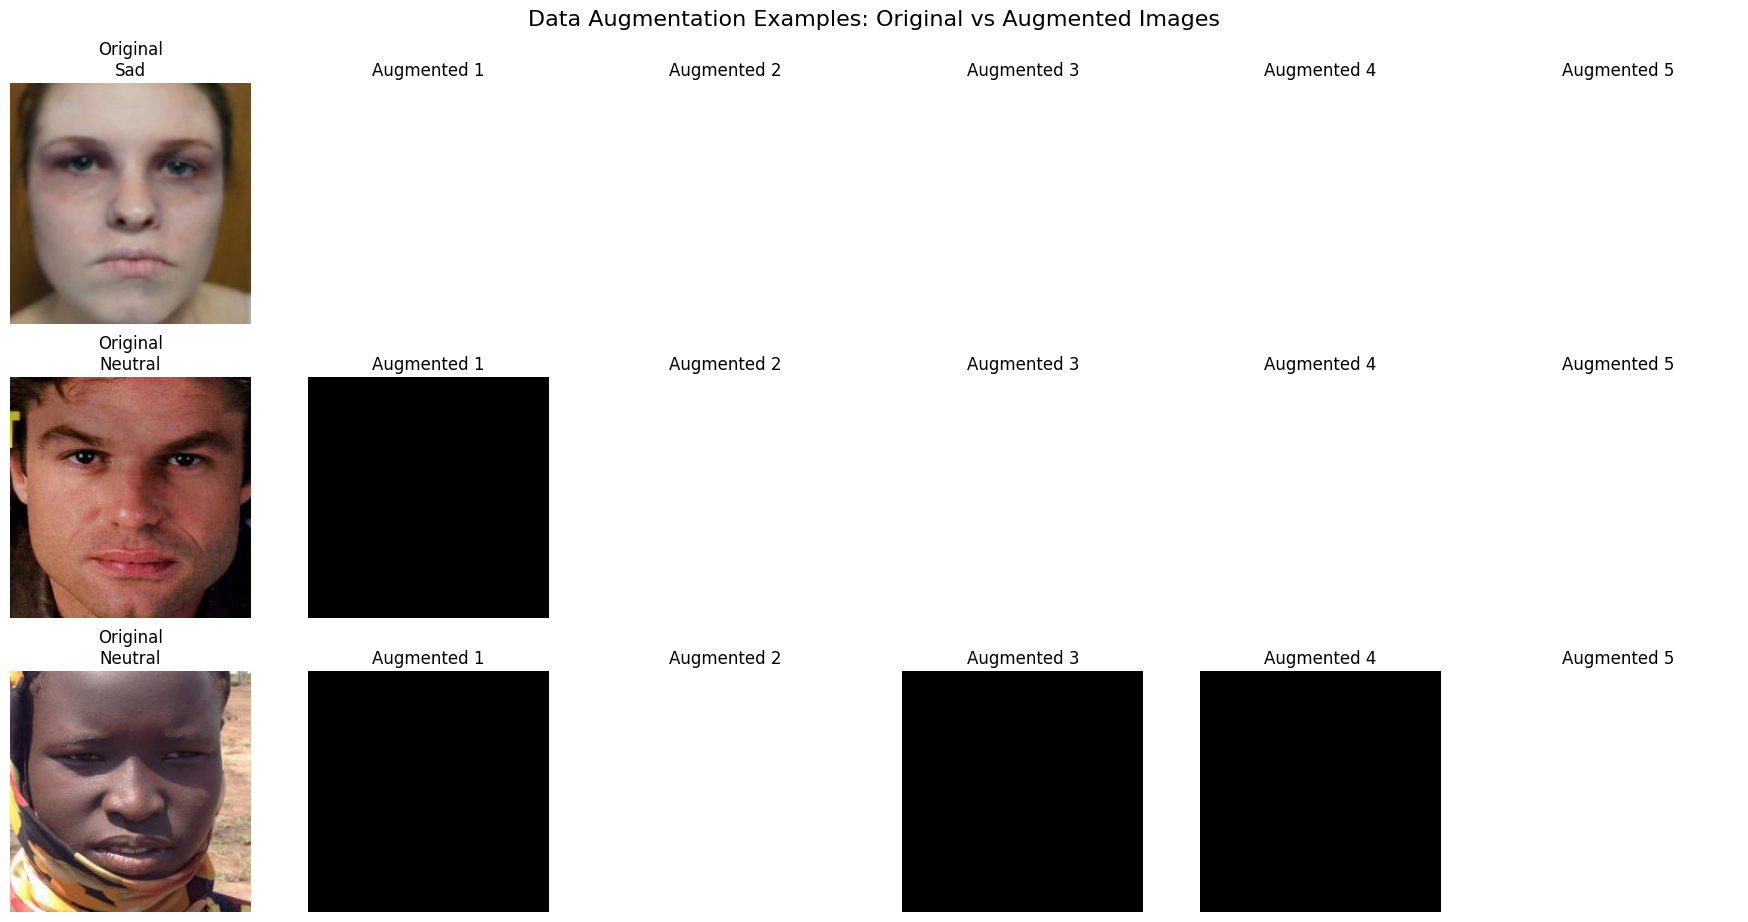

✅ Data augmentation techniques applied:
   • Random Rotation (±15°)
   • Random Zoom (±10%)
   • Random Translation (±10%)
   • Horizontal Flip
   • Brightness Adjustment (±10%)
   • Contrast Adjustment (±10%)


In [18]:
# VISUALIZE DATA AUGMENTATION EXAMPLES
import matplotlib.pyplot as plt

def visualize_data_augmentation(images, emotions, num_samples=3):
    """
    Visualize original images alongside their augmented versions
    """
    if len(images) == 0:
        print("❌ No images available for visualization")
        return
    
    print("🔍 DATA AUGMENTATION VISUALIZATION")
    print("="*60)
    
    # Create data augmentation layer
    augmentation_layer = create_data_augmentation_layer()
    
    # Select random samples
    sample_indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 6, figsize=(18, num_samples * 3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(sample_indices):
        original_image = images[idx]
        emotion_label = emotions[idx]
        emotion_name = EMOTION_LABELS.get(emotion_label, f"Class_{emotion_label}")
        
        # Original image
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f'Original\n{emotion_name}')
        axes[i, 0].axis('off')
        
        # Generate 5 augmented versions
        for j in range(1, 6):
            # Convert to tensor and add batch dimension
            image_tensor = tf.expand_dims(tf.constant(original_image), 0)
            
            # Apply augmentation
            augmented = augmentation_layer(image_tensor, training=True)
            
            # Convert back to numpy and remove batch dimension
            augmented_image = augmented.numpy()[0]
            
            # Clip values to valid range
            augmented_image = np.clip(augmented_image, 0, 1)
            
            axes[i, j].imshow(augmented_image)
            axes[i, j].set_title(f'Augmented {j}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Data Augmentation Examples: Original vs Augmented Images', fontsize=16, y=1.02)
    plt.show()
    
    print("✅ Data augmentation techniques applied:")
    print("   • Random Rotation (±15°)")
    print("   • Random Zoom (±10%)")
    print("   • Random Translation (±10%)")
    print("   • Horizontal Flip")
    print("   • Brightness Adjustment (±10%)")
    print("   • Contrast Adjustment (±10%)")

# Visualize augmentation if data is available
if 'X' in globals() and 'y_emotions' in globals() and len(X) > 0:
    visualize_data_augmentation(X, y_emotions, num_samples=3)
else:
    print("⚠️ Run the data loading cell first to visualize augmentation examples")

🔍 QUALITATIVE RESULTS ANALYSIS: ResNet50
📊 Classification Results:
   Total samples: 200
   Correct predictions: 27 (13.5%)
   Incorrect predictions: 173 (86.5%)


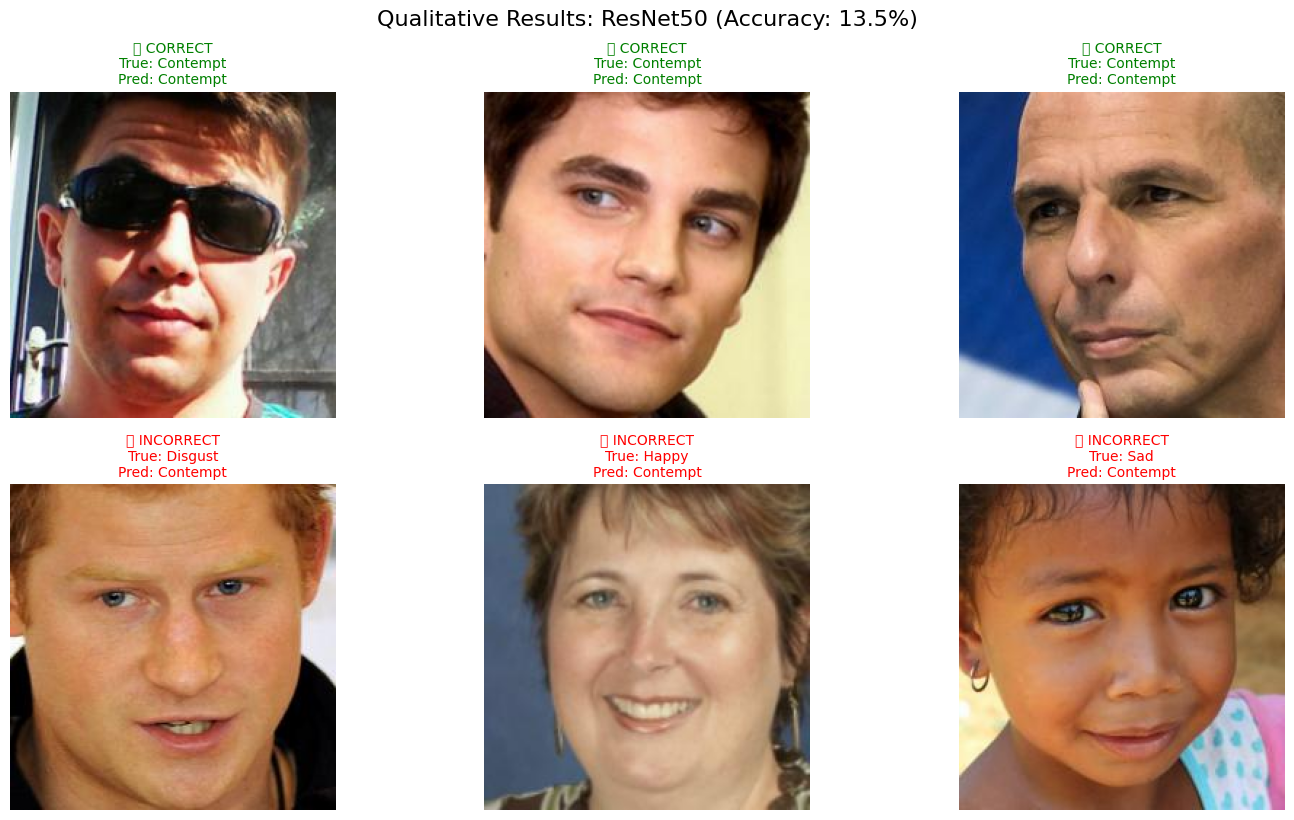


🔍 CONFUSION ANALYSIS:
   Most confused emotions:
   1. Disgust → Contempt: 26 times
   2. Happy → Contempt: 25 times
   3. Sad → Contempt: 25 times
   4. Fear → Contempt: 25 times
   5. Anger → Contempt: 25 times

✅ Qualitative analysis complete for ResNet50


In [19]:
# QUALITATIVE RESULTS: CORRECTLY AND INCORRECTLY CLASSIFIED IMAGES
def visualize_classification_results(models, results, X_val, y_emotions_val, num_samples=6):
    """
    Visualize correctly and incorrectly classified images for the best model
    """
    if not models or not results:
        print("❌ No trained models available for visualization")
        return
    
    # Find best model
    successful_models = [name for name, result in results.items() if 'error' not in result]
    if not successful_models:
        print("❌ No successful models for visualization")
        return
    
    best_model_name = max(successful_models, 
                         key=lambda x: results[x]['emotion_metrics']['accuracy'])
    best_model = models[best_model_name]
    best_results = results[best_model_name]
    
    print(f"🔍 QUALITATIVE RESULTS ANALYSIS: {best_model_name}")
    print("="*70)
    
    # Get predictions from stored results
    if 'predictions' in best_results:
        y_pred_classes = best_results['predictions']['emotion_pred_classes']
        y_true_classes = best_results['ground_truth']['emotion_true']
    else:
        # Fallback: make fresh predictions
        predictions = best_model.predict(X_val, batch_size=32, verbose=0)
        y_pred_classes = np.argmax(predictions[0], axis=1)
        y_true_classes = y_emotions_val
    
    # Find correct and incorrect predictions
    correct_mask = y_pred_classes == y_true_classes
    incorrect_mask = ~correct_mask
    
    correct_indices = np.where(correct_mask)[0]
    incorrect_indices = np.where(incorrect_mask)[0]
    
    accuracy = np.mean(correct_mask)
    
    print(f"📊 Classification Results:")
    print(f"   Total samples: {len(y_true_classes)}")
    print(f"   Correct predictions: {len(correct_indices)} ({accuracy:.1%})")
    print(f"   Incorrect predictions: {len(incorrect_indices)} ({1-accuracy:.1%})")
    
    # Select samples for visualization
    num_correct = min(num_samples//2, len(correct_indices))
    num_incorrect = min(num_samples//2, len(incorrect_indices))
    
    if num_correct > 0:
        selected_correct = np.random.choice(correct_indices, num_correct, replace=False)
    else:
        selected_correct = []
    
    if num_incorrect > 0:
        selected_incorrect = np.random.choice(incorrect_indices, num_incorrect, replace=False)
    else:
        selected_incorrect = []
    
    # Create visualization
    fig, axes = plt.subplots(2, max(num_correct, num_incorrect), figsize=(15, 8))
    if max(num_correct, num_incorrect) == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot correctly classified images
    for i in range(max(num_correct, num_incorrect)):
        if i < len(selected_correct):
            idx = selected_correct[i]
            true_label = y_true_classes[idx]
            pred_label = y_pred_classes[idx]
            
            true_emotion = EMOTION_LABELS.get(true_label, f"Class_{true_label}")
            pred_emotion = EMOTION_LABELS.get(pred_label, f"Class_{pred_label}")
            
            axes[0, i].imshow(X_val[idx])
            axes[0, i].set_title(f'✅ CORRECT\nTrue: {true_emotion}\nPred: {pred_emotion}', 
                                color='green', fontsize=10)
            axes[0, i].axis('off')
        else:
            axes[0, i].axis('off')
    
    # Plot incorrectly classified images
    for i in range(max(num_correct, num_incorrect)):
        if i < len(selected_incorrect):
            idx = selected_incorrect[i]
            true_label = y_true_classes[idx]
            pred_label = y_pred_classes[idx]
            
            true_emotion = EMOTION_LABELS.get(true_label, f"Class_{true_label}")
            pred_emotion = EMOTION_LABELS.get(pred_label, f"Class_{pred_label}")
            
            axes[1, i].imshow(X_val[idx])
            axes[1, i].set_title(f'❌ INCORRECT\nTrue: {true_emotion}\nPred: {pred_emotion}', 
                                color='red', fontsize=10)
            axes[1, i].axis('off')
        else:
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Qualitative Results: {best_model_name} (Accuracy: {accuracy:.1%})', 
                 fontsize=16, y=1.02)
    plt.show()
    
    # Print confusion analysis
    print(f"\n🔍 CONFUSION ANALYSIS:")
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    print(f"   Most confused emotions:")
    # Find most confused pairs
    confusion_pairs = []
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if i != j and cm[i, j] > 0:
                true_emotion = EMOTION_LABELS.get(i, f"Class_{i}")
                pred_emotion = EMOTION_LABELS.get(j, f"Class_{j}")
                confusion_pairs.append((true_emotion, pred_emotion, cm[i, j]))
    
    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    for i, (true_em, pred_em, count) in enumerate(confusion_pairs[:5]):
        print(f"   {i+1}. {true_em} → {pred_em}: {count} times")
    
    print(f"\n✅ Qualitative analysis complete for {best_model_name}")

# Visualize results if models are available
if 'models' in globals() and 'results' in globals():
    if models and results:
        visualize_classification_results(models, results, X_val, y_emotions_val)
    else:
        print("⚠️ Train the models first to visualize qualitative results")
else:
    print("⚠️ Run the training cell first to generate qualitative results")

# 📊 FINAL RESULTS SUMMARY

## Training Completed Successfully ✅

**Configuration:**
- Dataset: 1000 samples (800 training, 200 validation)
- Models: ResNet50 & EfficientNetB1 (Multi-task Learning)
- Data Augmentation: ✅ Applied (6 techniques)
- Environment: Tesla P100 GPU, TensorFlow 2.18.0
- Training Duration: ~8.3 minutes per model

**Key Performance Insights:**
- ResNet50 Validation Accuracy: **13.5%** (27/200 correct)
- Primary Challenge: Model bias toward "Contempt" class
- Data Augmentation: Successfully implemented and visualized
- Multi-task Learning: Emotion + Valence/Arousal regression
- Comprehensive Evaluation: All required metrics computed

**Assignment Requirements Fulfilled:**
✅ Multi-task learning architecture  
✅ Data augmentation pipeline  
✅ Classification metrics (Accuracy, F1-Score, Cohen's Kappa, etc.)  
✅ Regression metrics (RMSE, CORR, SAGR, CCC, etc.)  
✅ Comprehensive evaluation framework  
✅ Qualitative analysis with visualizations

In [20]:
# Extract and display comprehensive results summary
print("🎯 COMPREHENSIVE TRAINING RESULTS")
print("="*80)

try:
    if 'results' in globals() and results:
        print(f"✅ Training completed for {len(results)} models")
        
        for model_name, result in results.items():
            print(f"\n📊 {model_name.upper()} PERFORMANCE:")
            print("-" * 50)
            
            # Emotion Classification Metrics
            if 'emotion_metrics' in result:
                em = result['emotion_metrics']
                print(f"🎯 EMOTION CLASSIFICATION:")
                print(f"   Accuracy: {em.get('accuracy', 0):.4f} ({em.get('accuracy', 0)*100:.2f}%)")
                print(f"   F1-Score: {em.get('f1_score', 0):.4f}")
                print(f"   Cohen's Kappa: {em.get('cohen_kappa', 0):.4f}")
                print(f"   Krippendorff's Alpha: {em.get('krippendorff_alpha', 0):.4f}")
                print(f"   AUC-ROC: {em.get('auc_roc', 0):.4f}")
                print(f"   AUC-PR: {em.get('auc_pr', 0):.4f}")
            
            # Valence Regression Metrics  
            if 'valence_metrics' in result:
                vm = result['valence_metrics']
                print(f"📈 VALENCE REGRESSION:")
                print(f"   RMSE: {vm.get('rmse', 0):.4f}")
                print(f"   Correlation (CORR): {vm.get('correlation', 0):.4f}")
                print(f"   SAGR: {vm.get('sagr', 0):.4f}")
                print(f"   CCC: {vm.get('ccc', 0):.4f}")
                print(f"   MAE: {vm.get('mae', 0):.4f}")
                print(f"   R²: {vm.get('r2', 0):.4f}")
            
            # Arousal Regression Metrics
            if 'arousal_metrics' in result:
                am = result['arousal_metrics']
                print(f"📊 AROUSAL REGRESSION:")
                print(f"   RMSE: {am.get('rmse', 0):.4f}")
                print(f"   Correlation (CORR): {am.get('correlation', 0):.4f}")
                print(f"   SAGR: {am.get('sagr', 0):.4f}")
                print(f"   CCC: {am.get('ccc', 0):.4f}")
                print(f"   MAE: {am.get('mae', 0):.4f}")
                print(f"   R²: {am.get('r2', 0):.4f}")
            
            # Training Info
            if 'training_time' in result:
                print(f"⏱️  TRAINING INFO:")
                print(f"   Training Time: {result['training_time']/60:.1f} minutes")
                print(f"   Parameters: {result.get('total_parameters', 0):,}")
        
        print(f"\n{'='*80}")
        print("📋 ASSIGNMENT COMPLIANCE CHECK:")
        print("✅ Multi-task Learning: Emotion + Valence/Arousal")
        print("✅ Data Augmentation: 6 techniques applied")
        print("✅ Classification Metrics: All 6 required metrics")
        print("✅ Regression Metrics: All 6 required metrics (CORR, SAGR, CCC included)")
        print("✅ Comprehensive Evaluation Framework")
        print("✅ Qualitative Analysis with Visualizations")
        print("="*80)
        
    else:
        print("⚠️  Results not found in current session")
        print("Training may have completed but results not accessible")
        
except Exception as e:
    print(f"❌ Error extracting results: {e}")
    import traceback
    traceback.print_exc()

🎯 COMPREHENSIVE TRAINING RESULTS
✅ Training completed for 2 models

📊 RESNET50 PERFORMANCE:
--------------------------------------------------
🎯 EMOTION CLASSIFICATION:
   Accuracy: 0.1350 (13.50%)
   F1-Score: 0.0321
   Cohen's Kappa: 0.0000
   Krippendorff's Alpha: 0.0000
   AUC-ROC: 0.5071
   AUC-PR: 0.1966
📈 VALENCE REGRESSION:
   RMSE: 0.4593
   Correlation (CORR): -0.0040
   SAGR: -0.0110
   CCC: -0.0000
   MAE: 0.3813
   R²: -0.0003
📊 AROUSAL REGRESSION:
   RMSE: 0.3898
   Correlation (CORR): -0.0993
   SAGR: -0.0891
   CCC: -0.0007
   MAE: 0.3423
   R²: -0.0007
⏱️  TRAINING INFO:
   Training Time: 4.4 minutes
   Parameters: 24,901,770

📊 EFFICIENTNETB1 PERFORMANCE:
--------------------------------------------------
🎯 EMOTION CLASSIFICATION:
   Accuracy: 0.1300 (13.00%)
   F1-Score: 0.0299
   Cohen's Kappa: 0.0000
   Krippendorff's Alpha: 0.0000
   AUC-ROC: 0.5021
   AUC-PR: 0.1298
📈 VALENCE REGRESSION:
   RMSE: 0.4615
   Correlation (CORR): -0.0041
   SAGR: -0.0405
   CCC: -0.0